In [2]:
# Import all required libraries
from __future__ import division # For python 2.*

import numpy as np
import matplotlib.pyplot as plt
import mltools as ml

np.random.seed(0)
%matplotlib inline

In [4]:
# Data Loading
X = np.genfromtxt('data/X_train.txt', delimiter=None)
Y = np.genfromtxt('data/Y_train.txt', delimiter=None)

# The test data
Xte = np.genfromtxt('data/X_test.txt', delimiter=None)

Xtr, Xva, Ytr, Yva = ml.splitData(X, Y)
Xtr, Ytr = ml.shuffleData(Xtr, Ytr)

# Taking a subsample of the data so that trains faster.  You should train on whole data for homework and Kaggle.
Xt, Yt = Xtr[:4000], Ytr[:4000] 

In [8]:
def k_means(k):
    topSSD = 0
    
    Z = 0
    mu = 0
    ssd = np.inf
    for i in range(5):    
        tempZ, tempMu, tempSsd = ml.cluster.kmeans(Xt, K=k, init='random', max_iter=100)
        if tempSsd < ssd:
            Z = tempZ
            mu = tempMu
            ssd = tempSsd
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plotting the original data
    ax[0].scatter(Xt[:, 0], Xt[:, 1], c=Yt)

    # Plotting the clustered data
    ax[1].scatter(Xt[:, 0], Xt[:, 1], c=Z) # Plotting the data
    ax[1].scatter(mu[:, 0], mu[:, 1], s=500, marker='x', facecolor='black', lw=8) # Plotting the centroids
    ax[1].scatter(mu[:, 0], mu[:, 1], s=30000, alpha=.45, c=np.unique(Z)) # Lazy way of plotting the clusters area :)

    plt.show()

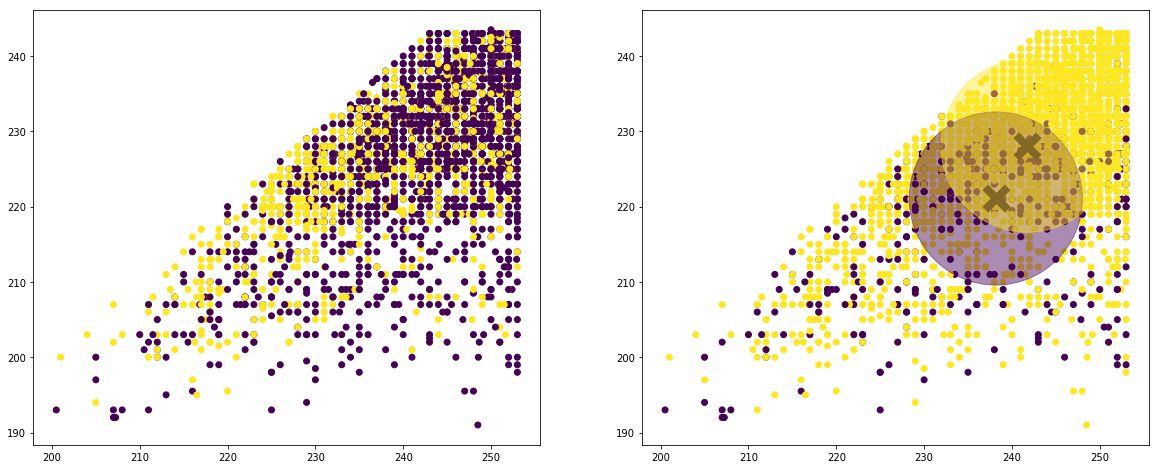

In [11]:
k_means(2)